# Introduction
In this part of the project I would like to build a model that helps me visualize the book "An Inquiry" by Adam Smith.

In [1]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
from econbooks import InquiryNatureCauseWealth

I have put some information about the book that we can retrieve just using the class I defined.

In [3]:
cause_of_wealth = InquiryNatureCauseWealth()

In [4]:
cause_of_wealth.title

'An Inquiry into the Nature and Causes of the Wealth of Nations'

In [5]:
cause_of_wealth.author

'Adam Smith'

Now let's get the text for our analysis. It will query the Gutenberg site and process the HTML book to extract the books paragraphs.

In [6]:
cause_of_wealth = cause_of_wealth.get_text()

In [7]:
len(cause_of_wealth)

2089

There is a total of 2089 paragraphs in the Adam Smith's book. Before applying any Machine learning technique, we need to clean the text and make it suitable for analysis. We are going to tokenize the text, remove stopwords.

In [8]:
# Convert the list to string
cause_of_wealth = "".join(cause_of_wealth)

In [9]:
sentences = sent_tokenize(cause_of_wealth)

In [10]:
len(sentences)

11752

In [11]:
sentences[200]

'All the inland parts of Africa, and all that part of Asia which lies any\r\n      considerable way north of the Euxine and Caspian seas, the ancient\r\n      Scythia, the modern Tartary and Siberia, seem, in all ages of the world,\r\n      to have been in the same barbarous and uncivilized state in which we find\r\n      them at present.'

What is more interesting is to tokenize the words. Every single word will form a token

In [12]:
tokens = word_tokenize(cause_of_wealth)

In [13]:
len(tokens)

428891

In [14]:
tokens[200:210]

['.',
 'The',
 'abundance',
 'or',
 'scantiness',
 'of',
 'this',
 'supply',
 ',',
 'too']

In [15]:
# Most common tokens
from collections import Counter

In [16]:
word_counts = Counter(tokens)
word_counts.most_common(10)

[(',', 35866),
 ('the', 29062),
 ('of', 24012),
 ('.', 11717),
 ('to', 11562),
 ('and', 10164),
 ('in', 8534),
 ('a', 6157),
 ('which', 4803),
 ('is', 4668)]

As we see through this example all the words are now distinct so we refer to them individually. However many tokens are useless for example the punctuations and words likes "the, or,is". We need to lower all the words and remove the punctuations and the stopwords.

In [17]:
stopwords.words("english")[10:15]

["you've", "you'll", "you'd", 'your', 'yours']

But before we remove them, we need to make sure all words are in lower case and that all punctuations are removes.

In [18]:
tokens = [token.lower() for token in tokens]
tokens = [token for token in tokens if token.isalpha()]

In [19]:
len(tokens)

375255

Now we can remove the stopwords

In [20]:
#tokens = [token for token in tokens if not token in set(stopwords.words("english"))]

In [21]:
#tokens[1:10]

In [22]:
#word_counts = Counter(tokens)
#word_counts.most_common(10)

# Word2vec model
From now we can build our model because the text is already cleaned

In [23]:
from gensim.models import word2vec

In [24]:
sents = [sent.lower().split() for sent in sentences]

In [25]:
# We stick with the default paramaters. it will create 100 dimensional vector for each
# word
model = word2vec.Word2Vec(
    min_count = 20,
    size = 300,
    alpha= 0.03
)

In [26]:
model.build_vocab(sents)

In [27]:
model.train(tokens, total_examples= model.corpus_count, epochs = 50)

(7713909, 87376600)

In [28]:
model.corpus_count

11752

In [29]:
model.init_sims(replace= True)

In [30]:
model.wv.most_similar("wealth")

[('individuals', 0.21812476217746735),
 ('profit', 0.1885257065296173),
 ('life', 0.18322862684726715),
 ('whatever', 0.17921429872512817),
 ('town,', 0.1705448031425476),
 ('over', 0.16218535602092743),
 ('supplying', 0.16142816841602325),
 ('coal', 0.1546359360218048),
 ('easy', 0.1524381935596466),
 ('consider', 0.15107673406600952)]

In [31]:
model.wv.most_similar("labour")

[('degradation', 0.20025867223739624),
 ('price.', 0.18355102837085724),
 ('unless', 0.1788335144519806),
 ('what', 0.1719619333744049),
 ('difficulty', 0.16623608767986298),
 ('invention', 0.165042906999588),
 ('idle', 0.1650128960609436),
 ('barbarous', 0.16450712084770203),
 ('knowledge', 0.162648007273674),
 ('or', 0.15703213214874268)]

In [32]:
all_words = model.wv.syn0

C:\Users\AXEL-C~3\science\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [33]:
from sklearn.manifold import TSNE

In [34]:
tsne = TSNE(n_components= 3, random_state= 1)

In [35]:
all_words_3dmatrix = tsne.fit_transform(all_words)

In [36]:
import pandas as pd
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_words_3dmatrix[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [37]:
points.head()

,word,x,y
0,the,24.024406,-91.673485
1,annual,-42.250889,-31.115057
2,labour,28.876017,-25.201988
3,of,52.123768,-66.182419
4,every,-3.119053,28.003063


In [40]:
points.dtypes

word     object
x       float64
y       float64
dtype: object

In [41]:
%matplotlib inline

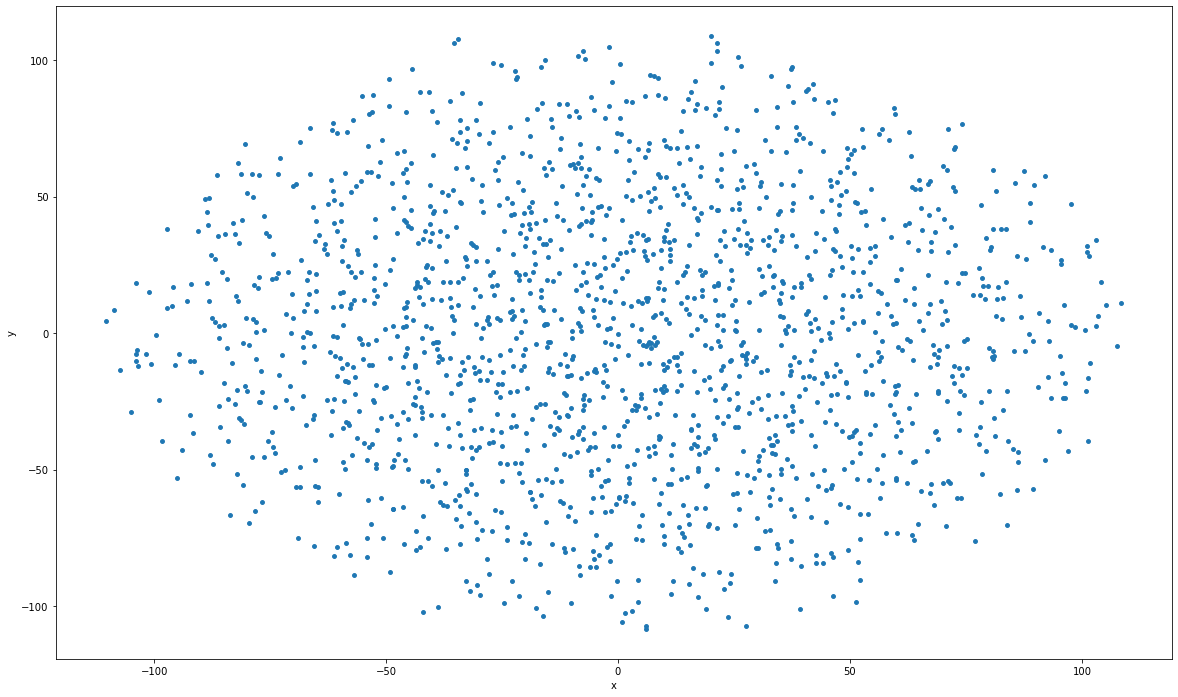

In [74]:
points.plot.scatter("x", "y", s=15, figsize=(20, 12))

In [79]:
import matplotlib.pyplot as plt
def plot_region(x_bounds, y_bounds):
    slices = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    print(slices.shape)
    ax = slices.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slices.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

(56, 3)


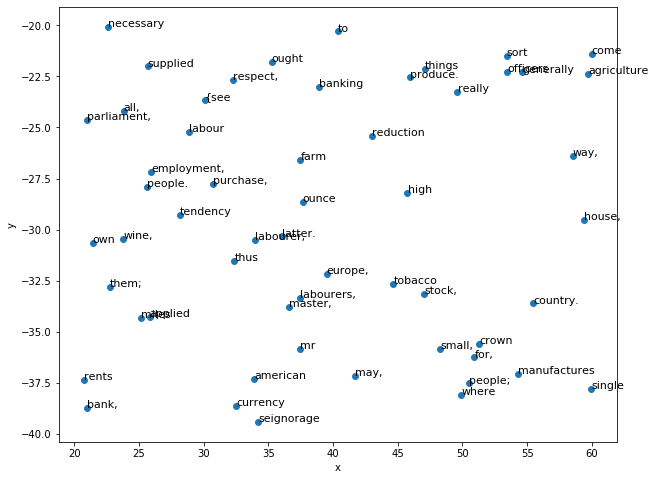

In [81]:
plot_region(x_bounds=(20, 60), y_bounds=(-40, -20))

In [82]:
from sklearn.decomposition import PCA

In [83]:
pca = PCA(n_components= 2, random_state=1)
pca = pca.fit_transform(all_words)

In [84]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, pca[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
points.head()

,word,x,y
0,the,-0.039355,0.099792
1,annual,-0.053778,-0.035255
2,labour,0.037065,-0.015704
3,of,-0.088804,-0.025042
4,every,-0.085647,-0.122721


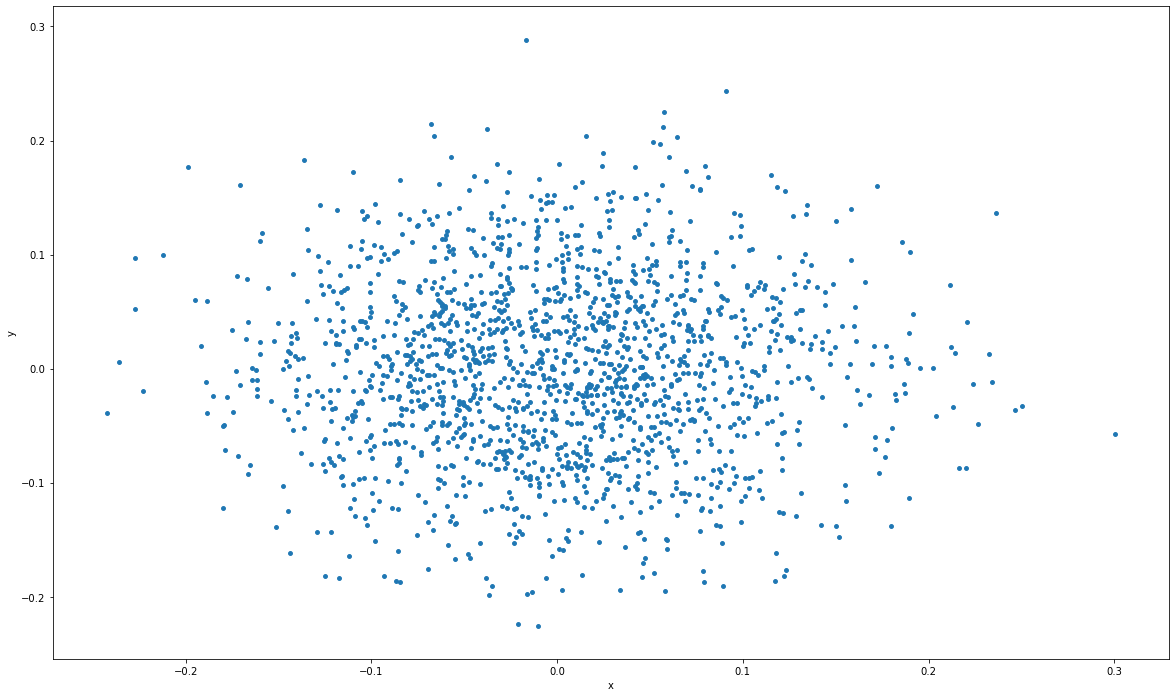

In [85]:
points.plot.scatter("x", "y", s=15, figsize=(20, 12))

(163, 3)


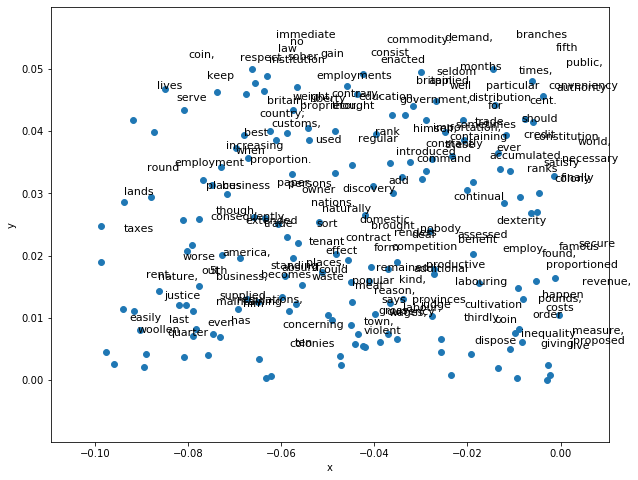

In [87]:
plot_region(x_bounds=(-0.1, 0), y_bounds=(0, 0.05))